In [1]:
#Import Libraries
import scipy.io as sio
import pandas as pd
import os
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from scipy.fft import fft, fftfreq
from scipy.special import rel_entr
from scipy.stats import entropy
import pywt
from scipy.signal import spectrogram
import seaborn as sns

In [2]:
#Mat files path
data_path = '/home/exouser/Electricity Time Series/'

In [3]:
#Checking file labels
files = ['APPLIANCES.mat', 'HVAC.mat', 'LIGHTING.mat', 'MAINS.mat', 'OTHER_LOADS.mat']

for file in files:
    mat_contents = sio.loadmat(os.path.join(data_path, file))
    print(f"Keys in {file}: {mat_contents.keys()}")

Keys in APPLIANCES.mat: dict_keys(['__header__', '__version__', '__globals__', 'y4'])
Keys in HVAC.mat: dict_keys(['__header__', '__version__', '__globals__', 'y2'])
Keys in LIGHTING.mat: dict_keys(['__header__', '__version__', '__globals__', 'y3'])
Keys in MAINS.mat: dict_keys(['__header__', '__version__', '__globals__', 'y1'])
Keys in OTHER_LOADS.mat: dict_keys(['__header__', '__version__', '__globals__', 'y5'])


In [4]:
data_path = '/home/exouser/Electricity Time Series/'

# Loading datasets
APPLIANCES = sio.loadmat(os.path.join(data_path, 'APPLIANCES.mat'))['y4'].flatten()
HVAC = sio.loadmat(os.path.join(data_path, 'HVAC.mat'))['y2'].flatten()
LIGHTING = sio.loadmat(os.path.join(data_path, 'LIGHTING.mat'))['y3'].flatten()
MAINS = sio.loadmat(os.path.join(data_path, 'MAINS.mat'))['y1'].flatten()
OTHER_LOADS = sio.loadmat(os.path.join(data_path, 'OTHER_LOADS.mat'))['y5'].flatten()

# Combining into a single DataFrame for easy handling
df = pd.DataFrame({
    'APPLIANCES': APPLIANCES,
    'HVAC': HVAC,
    'LIGHTING': LIGHTING,
    'MAINS': MAINS,
    'OTHER_LOADS': OTHER_LOADS
})

# see first few rows
df.head(10)

,APPLIANCES,HVAC,LIGHTING,MAINS,OTHER_LOADS
0,0.092943,0.101901,0.154932,0.729393,0.379618
1,0.092356,0.102186,0.151739,0.724624,0.378343
2,0.091770,0.102471,0.148550,0.719861,0.377070
3,0.091184,0.102756,0.145369,0.715110,0.375801
4,0.090599,0.103041,0.142200,0.710379,0.374539
5,0.090015,0.103326,0.139046,0.705672,0.373285
6,0.089432,0.103611,0.135912,0.700996,0.372041
7,0.088850,0.103895,0.132802,0.696357,0.370810
8,0.088270,0.104179,0.129719,0.691761,0.369594
9,0.087691,0.104462,0.126667,0.687214,0.368394


In [5]:
# Min-max normalization
df_normalized = (df - df.min()) / (df.max() - df.min())

# Denoising using Savitzky-Golay filter
window_length = 61  # Window size (must be odd)
polyorder = 3  # Polynomial order
df_denoised = df_normalized.apply(lambda x: savgol_filter(x, window_length, polyorder))

print(df_denoised.head(10))

   APPLIANCES      HVAC  LIGHTING     MAINS  OTHER_LOADS
0    0.109307  0.044310  0.186247  0.099183     0.348328
1    0.107912  0.044401  0.180529  0.097740     0.344494
2    0.106527  0.044492  0.174908  0.096323     0.340744
3    0.105151  0.044582  0.169386  0.094932     0.337080
4    0.103785  0.044672  0.163962  0.093567     0.333500
5    0.102428  0.044761  0.158637  0.092228     0.330004
6    0.101081  0.044851  0.153411  0.090915     0.326593
7    0.099742  0.044940  0.148283  0.089628     0.323265
8    0.098413  0.045028  0.143255  0.088368     0.320021
9    0.097092  0.045116  0.138327  0.087133     0.316860


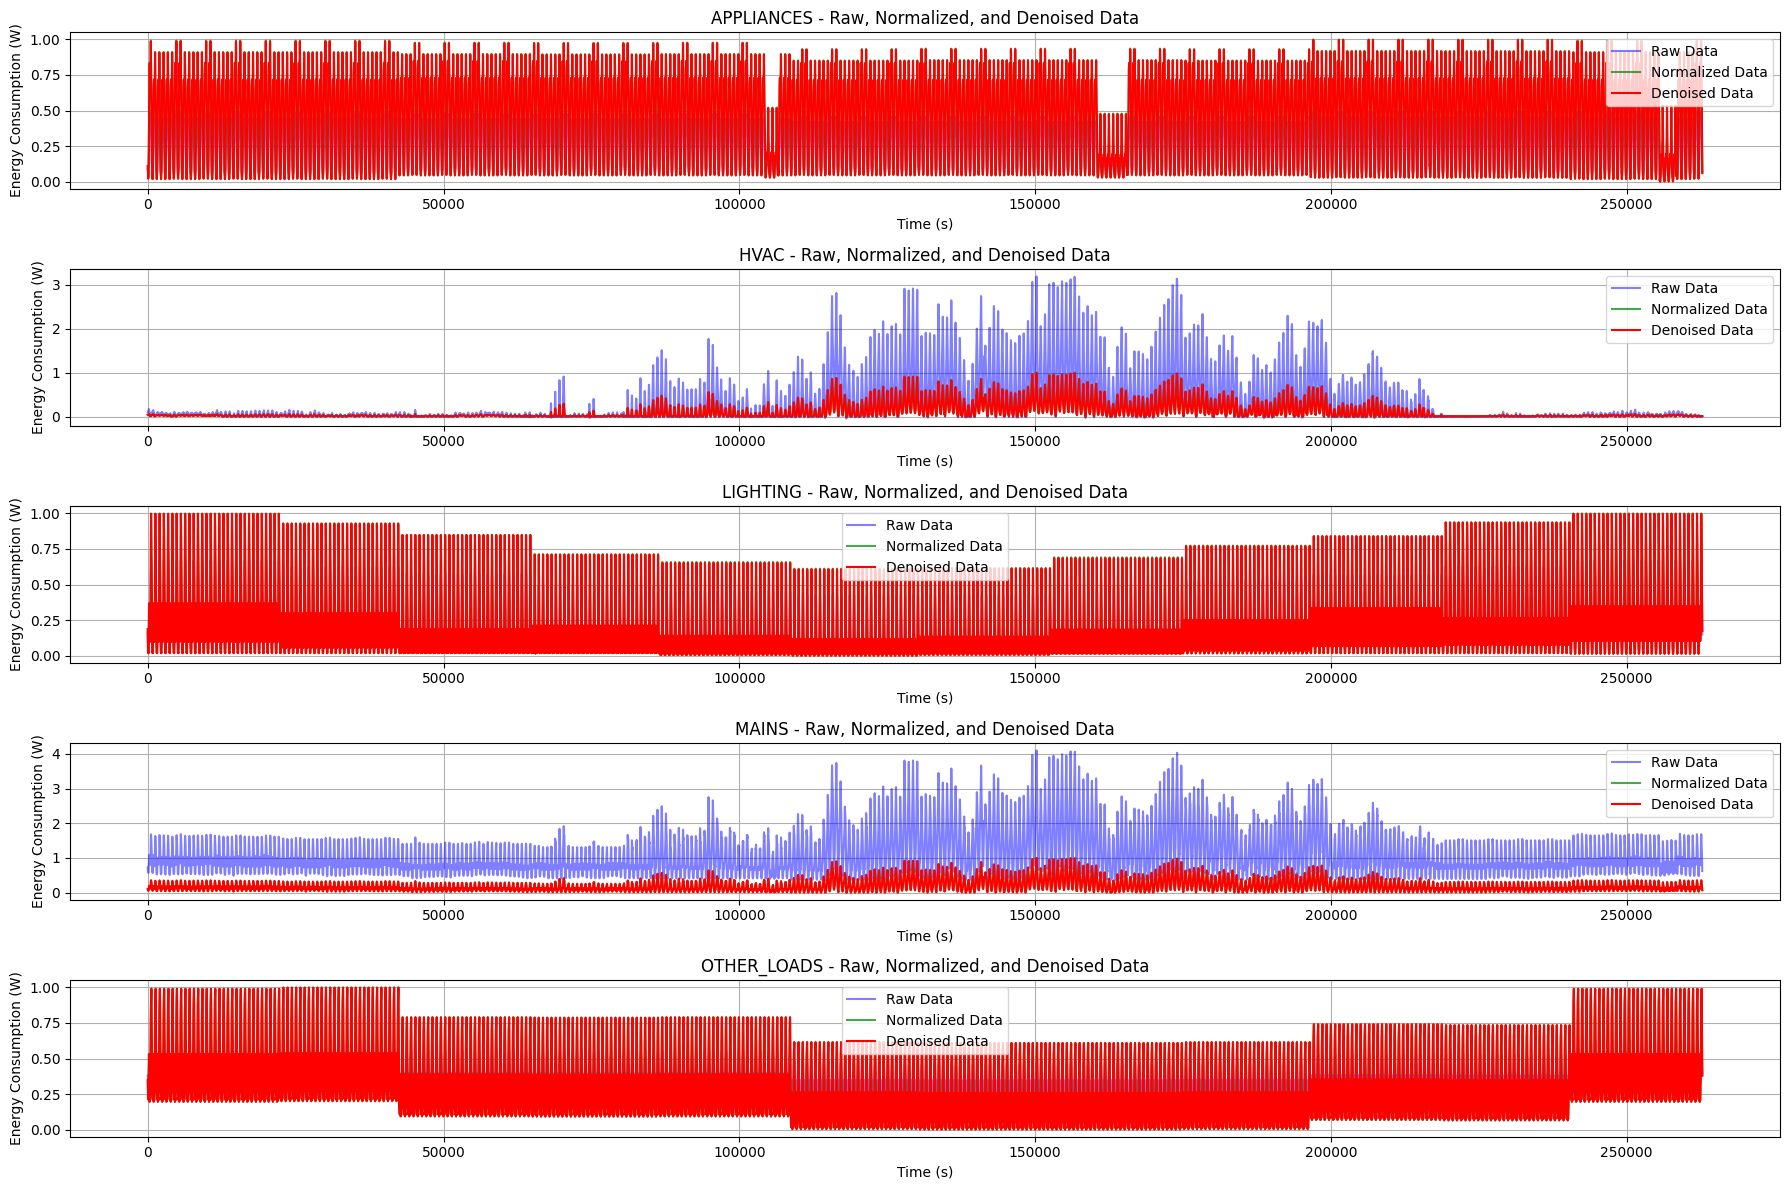

In [6]:
# Plot raw, normalized, and denoised data for each feature
features = df.columns
plt.figure(figsize=(18, 12))

for i, feature in enumerate(features, 1):
    plt.subplot(len(features), 1, i)
    
    # Plot raw data
    plt.plot(df[feature], label='Raw Data', color='blue', alpha=0.5)
    
    # Plot normalized data
    plt.plot(df_normalized[feature], label='Normalized Data', color='green', alpha=0.7)
    
    # Plot denoised data
    plt.plot(df_denoised[feature], label='Denoised Data', color='red')
    
    # Add labels and title
    plt.xlabel('Time (s)')
    plt.ylabel('Energy Consumption (W)')
    plt.title(f'{feature} - Raw, Normalized, and Denoised Data')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Euclidean Distance

Pairwise Euclidean Distances:
             APPLIANCES        HVAC    LIGHTING       MAINS  OTHER_LOADS
APPLIANCES     0.000000  225.737284  213.971975  178.639002   180.459377
HVAC         225.737284    0.000000  165.667197   59.860076   184.961899
LIGHTING     213.971975  165.667197    0.000000  127.338944    89.530882
MAINS        178.639002   59.860076  127.338944    0.000000   135.398377
OTHER_LOADS  180.459377  184.961899   89.530882  135.398377     0.000000


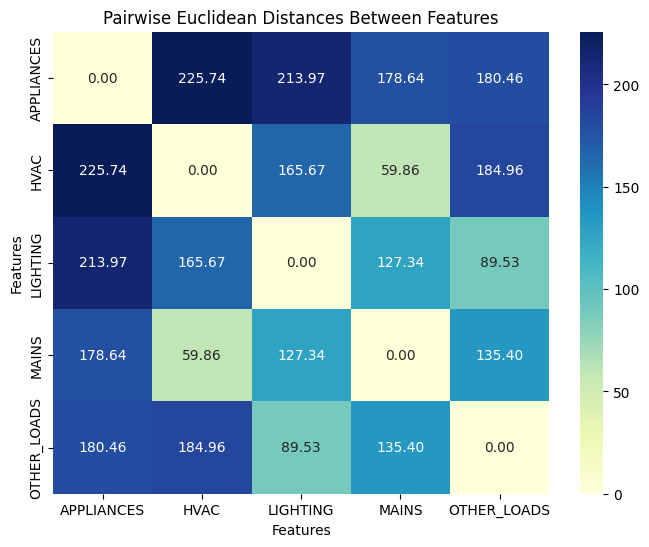

In [7]:
# Extract denoised data
denoised_features = df_denoised.columns

# Initialize a distance matrix
num_features = len(denoised_features)
distance_matrix = np.zeros((num_features, num_features))

# Compute pairwise Euclidean distances
for i, feature1 in enumerate(denoised_features):
    for j, feature2 in enumerate(denoised_features):
        distance = euclidean(df_denoised[feature1], df_denoised[feature2])
        distance_matrix[i, j] = distance

# Display the distance matrix
print("Pairwise Euclidean Distances:")
print(pd.DataFrame(distance_matrix, columns=denoised_features, index=denoised_features))

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    distance_matrix,
    annot=True,  # Display values in each cell
    fmt=".2f",   # Format values to 2 decimal places
    cmap="YlGnBu",  # Color map
    xticklabels=denoised_features,  # Feature names on x-axis
    yticklabels=denoised_features,  # Feature names on y-axis
)

# Add labels and title
plt.xlabel("Features")
plt.ylabel("Features")
plt.title("Pairwise Euclidean Distances Between Features")
plt.show()

Frequency Domain Analysis

In [8]:
# Compute FFT for each feature
fft_features = df_denoised.apply(lambda x: np.abs(fft(x)))

# Initialize a distance matrix for frequency domain
num_features = len(denoised_features)
fft_distance_matrix = np.zeros((num_features, num_features))

# Compute pairwise Euclidean distances in frequency domain
for i, feature1 in enumerate(denoised_features):
    for j, feature2 in enumerate(denoised_features):
        distance = euclidean(fft_features[feature1], fft_features[feature2])
        fft_distance_matrix[i, j] = distance

# Convert the distance matrix to a DataFrame for better readability
fft_distance_df = pd.DataFrame(fft_distance_matrix, columns=denoised_features, index=denoised_features)

# Display the FFT distance matrix
print("Pairwise Euclidean Distances in Frequency Domain:")
print(fft_distance_df)

Pairwise Euclidean Distances in Frequency Domain:
                APPLIANCES           HVAC      LIGHTING         MAINS  \
APPLIANCES        0.000000  107234.391082  77018.314476  80673.164283   
HVAC         107234.391082       0.000000  54350.807114  27634.086785   
LIGHTING      77018.314476   54350.807114      0.000000  38032.210870   
MAINS         80673.164283   27634.086785  38032.210870      0.000000   
OTHER_LOADS   52291.783330   70692.408946  34633.548007  46758.525731   

              OTHER_LOADS  
APPLIANCES   52291.783330  
HVAC         70692.408946  
LIGHTING     34633.548007  
MAINS        46758.525731  
OTHER_LOADS      0.000000  


KL Divergence

In [9]:
# Function to compute KL Divergence
def kl_divergence(p, q):
    # Ensure the distributions are normalized
    p = np.asarray(p, dtype=np.float64)
    q = np.asarray(q, dtype=np.float64)
    p = p / np.sum(p)  # Normalize p
    q = q / np.sum(q)  # Normalize q
    return entropy(p, q)  # Compute KL Divergence

# Compute histograms for each feature (to estimate probability distributions)
num_bins = 50  # Number of bins for histogram
histograms = {}
for feature in denoised_features:
    hist, bin_edges = np.histogram(df_denoised[feature], bins=num_bins, density=True)
    histograms[feature] = hist

# Initialize a KL Divergence matrix
kl_divergence_matrix = np.zeros((num_features, num_features))

# Compute pairwise KL Divergence
for i, feature1 in enumerate(denoised_features):
    for j, feature2 in enumerate(denoised_features):
        if i != j:  # Avoid computing KL Divergence of a feature with itself
            kl_divergence_matrix[i, j] = kl_divergence(histograms[feature1], histograms[feature2])

# Convert the KL Divergence matrix to a DataFrame for better readability
kl_divergence_df = pd.DataFrame(kl_divergence_matrix, columns=denoised_features, index=denoised_features)

# Display the KL Divergence matrix
print("Pairwise KL Divergence comparison:")
print(kl_divergence_df)

Pairwise KL Divergence comparison:
             APPLIANCES      HVAC  LIGHTING     MAINS  OTHER_LOADS
APPLIANCES     0.000000  1.403690  0.661982  0.968117     0.414205
HVAC           1.903711  0.000000  0.179136  0.718945     0.906217
LIGHTING       0.892013  0.210374  0.000000  0.330214     0.374434
MAINS          0.701675  0.584881  0.285995  0.000000     0.189296
OTHER_LOADS    0.418412  0.739210  0.317426  0.246598     0.000000


Wavelet Transform Analysis

In [10]:
# Function to perform wavelet transform and extract features
def wavelet_transform(series, wavelet='db1', level=4):
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(series, wavelet, level=level)
    
    # Extract approximation and detail coefficients
    approx = coeffs[0]  # Approximation coefficients (low-frequency components)
    details = coeffs[1:]  # Detail coefficients (high-frequency components)
    
    # Compute energy of each level
    energy = [np.sum(np.square(c)) for c in coeffs]
    
    return approx, details, energy

# Initialize a dictionary to store wavelet features
wavelet_features = {}

# Perform wavelet transform for each feature
for feature in denoised_features:
    approx, details, energy = wavelet_transform(df_denoised[feature])
    wavelet_features[feature] = {
        'approx': approx,
        'details': details,
        'energy': energy
    }

# Display wavelet features for one feature (e.g., APPLIANCES)
print("Wavelet Features for APPLIANCES:")
print("Approximation Coefficients:", wavelet_features['APPLIANCES']['approx'])
print("Detail Coefficients:", wavelet_features['APPLIANCES']['details'])
print("Energy:", wavelet_features['APPLIANCES']['energy'])

# Compare energy across features
energy_comparison = {feature: wavelet_features[feature]['energy'] for feature in denoised_features}
energy_comparison_df = pd.DataFrame(energy_comparison, index=[f'Level {i}' for i in range(len(energy_comparison['APPLIANCES']))])

print("\nEnergy Comparison Across Features:")
print(energy_comparison_df)

Wavelet Features for APPLIANCES:
Approximation Coefficients: [0.39668878 0.31595985 0.24336773 ... 1.23566087 0.82515368 0.42204075]
Detail Coefficients: [array([0.02127789, 0.01912632, 0.01728725, ..., 0.10208121, 0.10261765,
       0.09829986], shape=(16425,)), array([0.00772889, 0.00732038, 0.00694008, ..., 0.03609672, 0.03533363,
       0.03411834], shape=(32850,)), array([0.00277008, 0.00269538, 0.00262316, ..., 0.01240239, 0.01218756,
       0.01193276], shape=(65700,)), array([0.0009861 , 0.00097267, 0.00095947, ..., 0.00428798, 0.00424293,
       0.00419436], shape=(131400,))]
Energy: [np.float64(73806.1145431793), np.float64(51.00358794933964), np.float64(12.845318613375325), np.float64(3.2172931472793875), np.float64(0.8047179610272365)]

Energy Comparison Across Features:
           APPLIANCES          HVAC      LIGHTING         MAINS   OTHER_LOADS
Level 0  73806.114543  10502.302956  26268.166101  17436.754106  41435.838329
Level 1     51.003588      6.555417     65.695615 

Spectrogram Analysis

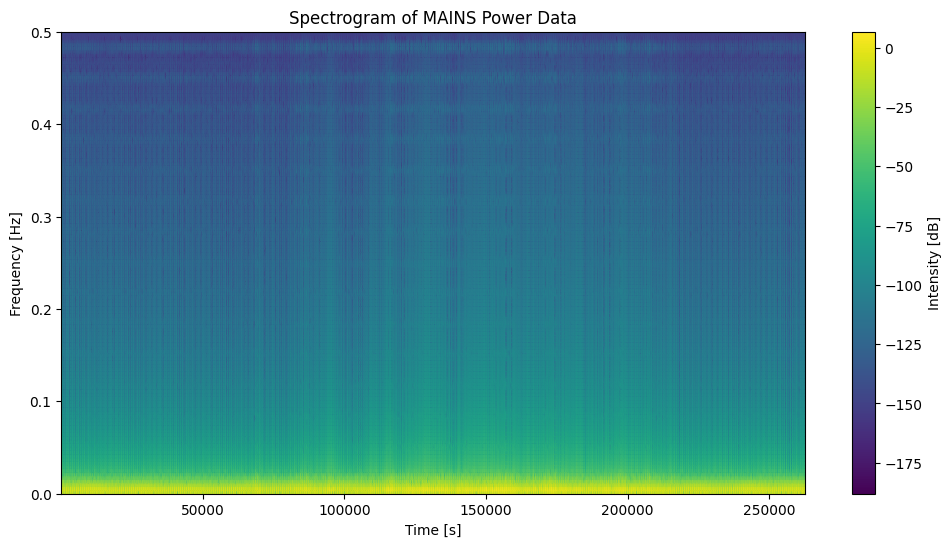

In [11]:
# Compute the spectrogram for MAINS data
frequencies, times, Sxx = spectrogram(
    df_denoised['MAINS'],  # Use the denoised MAINS data
    fs=1,  # Sampling frequency (1 Hz)
    nperseg=256,  # Length of each segment
    noverlap=128,  # Overlap between segments
    window='hann'  # Window function
)

# Plot the spectrogram
plt.figure(figsize=(12, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
plt.colorbar(label='Intensity [dB]')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Spectrogram of MAINS Power Data')
plt.show()

Motif Detection Using Matrix Profile

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

# Use the denoised MAINS data for motif detection
mains_data = df_denoised['MAINS'].values

# Set the window size (length of the subsequence to analyze)
window_size = 1440  # Example: 1440 samples = 24 hours (1 sample per second)

# Function to compute distances between subsequences
def compute_distances(data, window_size):
    n = len(data)
    distances = np.zeros(n - window_size + 1)
    
    for i in range(n - window_size + 1):
        subsequence = data[i:i + window_size]
        for j in range(i + 1, n - window_size + 1):
            distances[i] += euclidean(subsequence, data[j:j + window_size])
    
    return distances

# Compute distances between subsequences
distances = compute_distances(mains_data, window_size)

# Find the motif (subsequence with the smallest distance)
motif_start = np.argmin(distances)
motif_end = motif_start + window_size

# Plot the MAINS data and highlight the motif
plt.figure(figsize=(12, 6))
plt.plot(mains_data, label='MAINS Data')
plt.axvspan(motif_start, motif_end, color='red', alpha=0.3, label='Motif')
plt.title('MAINS Power Data with Detected Motif')
plt.xlabel('Time [s]')
plt.ylabel('Energy Consumption [W]')
plt.legend()
plt.show()

# Display the motif location
print(f"Motif Location: Starts at {motif_start} and ends at {motif_end}")